# Flair NLP Framework

In [3]:
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
import time
import joblib
from flair.data import Corpus, Sentence
from flair.datasets import ClassificationCorpus, CSVClassificationCorpus, TREC_6
from flair.embeddings import WordEmbeddings, FlairEmbeddings, DocumentLSTMEmbeddings, TransformerDocumentEmbeddings, StackedEmbeddings
from flair.models import TextClassifier
from flair.trainers import ModelTrainer
from flair.visual.training_curves import Plotter
from flair.hyperparameter.param_selection import SearchSpace, Parameter
from flair.hyperparameter.param_selection import TextClassifierParamSelector, OptimizationValue
from hyperopt import hp
from pathlib import Path
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_predict, GridSearchCV
from typing import List
import seaborn as sns
import tqdm

#from google.colab import drive
#drive.mount('/content/drive')

import torch
from torch.optim.adam import Adam
torch.cuda.is_available()


False

# Paths

In [8]:
# Parent paths
google_path = '/content/drive/My Drive/'
#local_path = '/Users/victoriazevallos/Desktop/Exercises & Records MSDS/FSS 2022/Projects/Group Project/Oscar_Project/detecting_harmful_content/'
local_path = '/home/v.zevallosm/detecting_harmful_content/'
parent_path = local_path

#Specific paths 
path_oscar_en_1 = parent_path+"data/raw/oscar_data/en_meta/en_meta_part_1.jsonl"
#path_oscar_en_1 = "en_meta_part_1.jsonl"

path_model_distilbert = parent_path+"models/English/Bert_based_approach/Harmful_and_Cyberbullying/Distilbert/final-model.pt"
path_model_distilroberta = parent_path+"models/English/Bert_based_approach/Harmful_and_Cyberbullying/Distilroberta/final-model.pt"


# Load Oscar data

In [9]:
df_en = pd.read_json(path_oscar_en_1, lines=True)
df_en

,content,metadata,warc_headers
0,Botany 2013 - Phylogenetic relationships in Br...,"{'identification': {'label': 'en', 'prob': 0.6...","{'content-length': '3090', 'warc-record-id': '..."
1,HOW EXACTLY TO MEET SHEMALES Meeting shemales ...,"{'identification': {'label': 'en', 'prob': 0.7...",{'warc-refers-to': '<urn:uuid:0244a561-2fe4-40...
2,Message (778) 294-7737Call (778) 294-7737Get d...,"{'identification': {'label': 'en', 'prob': 0.6...","{'content-length': '1498', 'warc-block-digest'..."
3,Aarambh India FX is a premier name in the real...,"{'identification': {'label': 'en', 'prob': 0.9...","{'content-length': '1397', 'warc-type': 'conve..."
4,"First described over 100 years ago, B. megater...","{'identification': {'label': 'en', 'prob': 0.6...",{'warc-block-digest': 'sha1:GOX4ZR3A4AO56LTX2X...
5,"From logo design to video animation, web devel...","{'identification': {'label': 'en', 'prob': 0.8...","{'warc-identified-content-language': 'eng,spa'..."
6,Please note: Colours are a guide only and are ...,"{'identification': {'label': 'en', 'prob': 0.9...","{'warc-identified-content-language': 'eng', 'w..."
7,"September 29, 2017 September 28, 2017 1 Commen...","{'identification': {'label': 'en', 'prob': 0.9...","{'content-length': '15372', 'warc-identified-c..."
8,"John Percival—Anthropologist, Writer, Televisi...","{'identification': {'label': 'en', 'prob': 0.9...",{'warc-block-digest': 'sha1:Y522QSHV2IVLF2X5TC...
9,"Have you ever enjoyed a delicious meal, only t...","{'identification': {'label': 'en', 'prob': 0.7...",{'warc-record-id': '<urn:uuid:aeae662a-ca7b-4b...


In [10]:
df_en = pd.read_json(path_oscar_en_1, lines=True)
df_en = pd.concat([df_en, df_en["warc_headers"].apply(pd.Series)], axis=1)
df_en = pd.concat([df_en, df_en["metadata"].apply(pd.Series)], axis=1)
df_en.drop(columns="warc_headers")
df_en.drop(columns="metadata")
df_en

,content,metadata,warc_headers,content-length,warc-record-id,warc-date,content-type,warc-identified-content-language,warc-target-uri,warc-type,warc-block-digest,warc-refers-to,identification,annotation,sentence_identifications
0,Botany 2013 - Phylogenetic relationships in Br...,"{'identification': {'label': 'en', 'prob': 0.6...","{'content-length': '3090', 'warc-record-id': '...",3090,<urn:uuid:ee53a5ad-6feb-4830-b758-0c2dcef7508b>,2021-11-28T11:32:36Z,text/plain,eng,http://2013.botanyconference.org/engine/search...,conversion,sha1:RN44BZN6NWYSVVPHHLB35D3INWUIJINP,<urn:uuid:f119d039-22b8-41b6-acd8-252e0300ffdd>,"{'label': 'en', 'prob': 0.62555844}","[short_sentences, header]","[None, {'label': 'en', 'prob': 0.8633837}, {'l..."
1,HOW EXACTLY TO MEET SHEMALES Meeting shemales ...,"{'identification': {'label': 'en', 'prob': 0.7...",{'warc-refers-to': '<urn:uuid:0244a561-2fe4-40...,8040,<urn:uuid:7b1e58f1-f6fe-42f4-8e2f-df3be702b001>,2021-11-28T11:33:38Z,text/plain,eng,http://360personnel.com.au/singles-sites-2/how...,conversion,sha1:GRX3LDEK4L3NCMJ4J65FDKAYDLYZLMBF,<urn:uuid:0244a561-2fe4-400d-8186-e75f57dad8f3>,"{'label': 'en', 'prob': 0.73943275}","[short_sentences, header, footer]","[{'label': 'en', 'prob': 0.9274032999999999}, ..."
2,Message (778) 294-7737Call (778) 294-7737Get d...,"{'identification': {'label': 'en', 'prob': 0.6...","{'content-length': '1498', 'warc-block-digest'...",1498,<urn:uuid:369be0e9-4159-4c46-9095-624b73a383ad>,2021-11-28T11:14:18Z,text/plain,eng,http://49thparallelpharmacy.com/,conversion,sha1:S2LJ6QCWYIP4ZANPPMEEKJNYJM4TAB3K,<urn:uuid:13869ce2-1b07-43e0-ae15-8187e4e82b85>,"{'label': 'en', 'prob': 0.6968824}","[short_sentences, header, footer]","[None, None, {'label': 'en', 'prob': 0.9437991..."
3,Aarambh India FX is a premier name in the real...,"{'identification': {'label': 'en', 'prob': 0.9...","{'content-length': '1397', 'warc-type': 'conve...",1397,<urn:uuid:763e5edc-ba7d-4adf-96c9-6a511a47d6d6>,2021-11-28T12:36:55Z,text/plain,eng,http://aarambhindiafx.com/energy.php,conversion,sha1:QO6P67WILB6RJI3HKMOJW5UZH7NYSUWK,<urn:uuid:981f1d60-ff68-43e5-8cef-62768d0e4a5b>,"{'label': 'en', 'prob': 0.9333187}",[tiny],"[{'label': 'en', 'prob': 0.88418216}, {'label'..."
4,"First described over 100 years ago, B. megater...","{'identification': {'label': 'en', 'prob': 0.6...",{'warc-block-digest': 'sha1:GOX4ZR3A4AO56LTX2X...,2595,<urn:uuid:35fa39a6-e146-42c0-9d92-37b31c088635>,2021-11-28T11:20:45Z,text/plain,"pol,eng",http://abo.com.pl/pl/c/Bacillus-megaterium/377...,conversion,sha1:GOX4ZR3A4AO56LTX2XRLQO2DU7XOEUMH,<urn:uuid:a97e1eed-2e35-418f-acac-a3663c606b44>,"{'label': 'en', 'prob': 0.6873574}","[short_sentences, footer]","[{'label': 'en', 'prob': 0.97394717}, {'label'..."
5,"From logo design to video animation, web devel...","{'identification': {'label': 'en', 'prob': 0.8...","{'warc-identified-content-language': 'eng,spa'...",149,<urn:uuid:f451f1c6-b90f-4a92-91a7-d677b121fc42>,2021-11-28T11:40:45Z,text/plain,"eng,spa",http://ace.com.do/main-3/bg1/,conversion,sha1:45NA4F2CFCSJXXPHCD5KQA3ZLEVSFDUS,<urn:uuid:fc895c9e-347a-44e7-84dd-f1e8d5403513>,"{'label': 'en', 'prob': 0.89382976}",[tiny],"[{'label': 'en', 'prob': 0.89382976}]"
6,Please note: Colours are a guide only and are ...,"{'identification': {'label': 'en', 'prob': 0.9...","{'warc-identified-content-language': 'eng', 'w...",108,<urn:uuid:a22efb4f-0553-49ab-bfd7-7269e0528592>,2021-11-28T12:33:27Z,text/plain,eng,http://acegroup.clothesrail.co/?action=dS&cate...,conversion,sha1:UZXXG2VWJWI7U72LRJ77NQ2MAOZSTIG2,<urn:uuid:0c8cd1f1-b82e-4544-a6ee-8c41a04aad13>,"{'label': 'en', 'prob': 0.9298034}",[tiny],"[{'label': 'en', 'prob': 0.9298034}]"
7,"September 29, 2017 September 28, 2017 1 Commen...","{'identification': {'label': 'en', 'prob': 0.9...","{'content-length': '15372', 'warc-identified-c...",15372,<urn:uuid:0b2d4c30-3208-45be-b70a-bca051302775>,2021-11-28T11:34:26Z,text/plain,eng,http://activehistory.ca/2017/09/lessons-for-th...,conversion,sha1:Y7SCX

In [11]:
df_content = df_en[['content']]
df_content

,content
0,Botany 2013 - Phylogenetic relationships in Br...
1,HOW EXACTLY TO MEET SHEMALES Meeting shemales ...
2,Message (778) 294-7737Call (778) 294-7737Get d...
3,Aarambh India FX is a premier name in the real...
4,"First described over 100 years ago, B. megater..."
5,"From logo design to video animation, web devel..."
6,Please note: Colours are a guide only and are ...
7,"September 29, 2017 September 28, 2017 1 Commen..."
8,"John Percival—Anthropologist, Writer, Televisi..."
9,"Have you ever enjoyed a delicious meal, only t..."


# Predict Label

## Distilbert

In [13]:
model_distilbert = TextClassifier.load(path_model_distilbert)

2022-07-11 10:08:01,890 loading file /home/v.zevallosm/detecting_harmful_content/models/English/Bert_based_approach/Harmful_and_Cyberbullying/Distilbert/final-model.pt


In [14]:
ls_pred = []
ls_conf = []
start_time = time.time()

for i, c in enumerate(df_content['content']):
    pred = Sentence(c)
    model_distilbert.predict(pred)
    ls_pred.append(pred.labels[0].to_dict()['value'])
    ls_conf.append(pred.labels[0].to_dict()['confidence'])

print("--- Execution time: %s seconds ---\n" %round(time.time() - start_time, 2))
    
df_content['b_pred'] = ls_pred
df_content['b_confidence'] = ls_conf


--- Execution time: 23529.01 seconds ---



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [15]:
df_content

,content,b_pred,b_confidence
0,Botany 2013 - Phylogenetic relationships in Br...,__label__1,0.998952
1,HOW EXACTLY TO MEET SHEMALES Meeting shemales ...,__label__1,0.999705
2,Message (778) 294-7737Call (778) 294-7737Get d...,__label__1,0.996155
3,Aarambh India FX is a premier name in the real...,__label__1,0.996396
4,"First described over 100 years ago, B. megater...",__label__1,0.997593
5,"From logo design to video animation, web devel...",__label__0,0.999652
6,Please note: Colours are a guide only and are ...,__label__0,0.998776
7,"September 29, 2017 September 28, 2017 1 Commen...",__label__1,0.999897
8,"John Percival—Anthropologist, Writer, Televisi...",__label__1,0.999936
9,"Have you ever enjoyed a delicious meal, only t...",__label__1,0.995691


No handles with labels found to put in legend.


__label__1    0.786524
__label__0    0.213476
Name: b_pred, dtype: float64


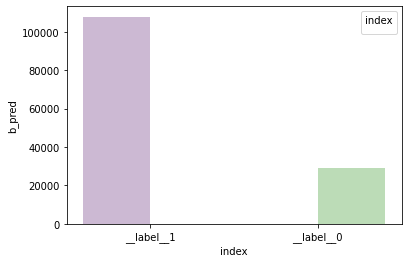

In [16]:
sns.barplot( x='index',y='b_pred', hue='index', 
            data=pd.DataFrame(df_content['b_pred'].value_counts()).reset_index(), 
            palette="PRGn")
print(df_content.b_pred.value_counts()/len(df_content))

## Distilroberta

In [17]:
model_distilroberta = TextClassifier.load(path_model_distilroberta)

2022-07-11 16:40:26,989 loading file /home/v.zevallosm/detecting_harmful_content/models/English/Bert_based_approach/Harmful_and_Cyberbullying/Distilroberta/final-model.pt


In [ ]:

ls_pred = []
ls_conf = []
start_time = time.time()

for i, c in enumerate(df_content['content']):
    pred = Sentence(c)
    model_distilroberta.predict(pred)
    ls_pred.append(pred.labels[0].to_dict()['value'])
    ls_conf.append(pred.labels[0].to_dict()['confidence'])

print("--- Execution time: %s seconds ---\n" %round(time.time() - start_time, 2))
    
df_content['rb_pred'] = ls_pred
df_content['rb_confidence'] = ls_conf


In [ ]:
df_content

In [ ]:
sns.barplot( x='index',y='rb_pred', hue='index', 
            data=pd.DataFrame(df_content['rb_pred'].value_counts()).reset_index(), 
            palette="PRGn")
print(df_content.rb_pred.value_counts()/len(df_content))